# 04_Model_Development notebook

**The objective of this notebook is to develop a multi-class text classification model using transformers architecture to classify autonomous vehicles disengagement categories based on the disengagement description.**

inspiration: https://colab.research.google.com/github/abhimishra91/transformers-tutorials/blob/master/transformers_multiclass_classification.ipynb#scrollTo=ZG_SVc-QqNsS

modeling steps are:
- Load and preprocess the dataset.
- Fine-tune the DistilBERT model.
- Evaluate the model.
- Plot the training and validation metrics.

## 1. Imports and Installations

In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt

#data encoding and processing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

#DistilBERT model
from transformers import DistilBertTokenizer, DistilBertModel, get_linear_schedule_with_warmup

#model evaluation
from sklearn.metrics import classification_report


In [2]:
# I'm using google colab to run this model so I'm setting up the GPU usage:

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

## 2. Read CSV

In [3]:
reports = pd.read_csv('./data/reports_condensed.csv')

In [4]:
reports.shape

(17454, 2)

In [5]:
reports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17454 entries, 0 to 17453
Data columns (total 2 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   disengagement_description  17454 non-null  object
 1   disengagement_category     17454 non-null  object
dtypes: object(2)
memory usage: 272.8+ KB


In [6]:
reports['disengagement_category'].unique()

array(['perception issues', 'driver intervention', 'planning issues',
       'control', 'hardware issues', 'localization & mapping issues',
       'environmental factors', 'other', 'traffic'], dtype=object)

## 2. Feature Engineering

In [7]:
# Encode the categories using LabelEncoder
label_encoder = LabelEncoder()
reports['encoded_category'] = label_encoder.fit_transform(reports['disengagement_category'])

In [8]:
reports['encoded_category'].unique()

array([6, 1, 7, 0, 3, 4, 2, 5, 8])

In [9]:
reports.head()

,disengagement_description,disengagement_category,encoded_category
0,Safety Driver disengaged autonomous mode upon ...,perception issues,6
1,Safety Driver disengaged autonomous mode due d...,driver intervention,1
2,Safety Driver disengaged autonomous mode due t...,perception issues,6
3,Safety Driver disengaged autonomous mode upon ...,perception issues,6
4,Safety Driver disengaged autonomous mode as a ...,driver intervention,1


In [10]:
reports.encoded_category.value_counts()

encoded_category
6    6113
7    6063
1    2276
3    1694
2     296
5     292
0     263
4     249
8     208
Name: count, dtype: int64

## 3. Models

In [11]:
# Defining some key variables that will be used later on in the training

MAX_LEN = 256   #The maximum sequence length for tokenized inputs, see token length frequency plot.
TRAIN_BATCH_SIZE = 16    #The number of samples per gradient update for training dataset. Currently using google colabs pro GPU L4.
VALID_BATCH_SIZE = 8    # and validation dataset
EPOCHS = 10              # The number of times the entire training dataset is passed through the model. Use earlystopping later.
LEARNING_RATE = 3e-05    #The step size at each iteration while moving towards a minimum of the loss function. 3e-05 is the common lr starting point.

#define tokenizer: distilbert-base-uncased is used because word capitalization is not important here and I want to reduce the model complexity.
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### Token Length Frequency Plot

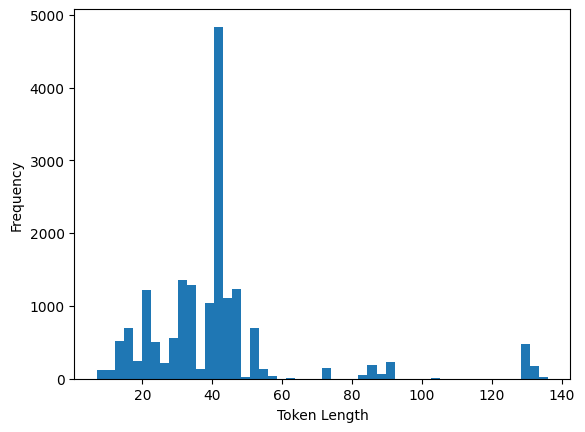

In [12]:
#the token lengths averages around 40 tokens and the maximum is approximately 140.

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')
lengths = [len(tokenizer.encode(text, add_special_tokens=True)) for text in reports['disengagement_description']]
plt.hist(lengths, bins=50)
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.show()

In [13]:
# The Triage class extends the PyTorch Dataset class to handle text data for training a model. It tokenizes the input text descriptions and prepares them for model input.


class Triage(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe) # Store the length of the dataframe
        self.data = dataframe # Store dataframe
        self.tokenizer = tokenizer #store tokenizer
        self.max_len = max_len #store max_len

    def __getitem__(self, index):
        title = str(self.data.disengagement_description[index])  #set the disengagement_description to be the title
        title = " ".join(title.split())   #remove any any extra space
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),  #convert input ids to tensor
            'mask': torch.tensor(mask, dtype=torch.long),   #convert attention mask to tensor
            'targets': torch.tensor(self.data.encoded_category[index], dtype=torch.long)
        }

    def __len__(self):
        return self.len

In [14]:
# Creating the dataset and dataloader for the neural network

train_size = 0.8  #train sample size 80%, test size 20%
train_dataset=reports.sample(frac=train_size,random_state=200)  #train set: sample at random (in this model I don't care about the dates)
test_dataset=reports.drop(train_dataset.index).reset_index(drop=True) # test set: createed by dropping the training dataset indices from the original dataset, and resetting the index for the test dataset
train_dataset = train_dataset.reset_index(drop=True) #also resetting index for train set

In [15]:
#check the shape of full, train, and test datasets
print("FULL Dataset: {}".format(reports.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

FULL Dataset: (17454, 3)
TRAIN Dataset: (13963, 3)
TEST Dataset: (3491, 3)


In [16]:
# Initialize the training dataset and test dataset using the Triage class, which tokenizes the data and prepares it for model training
training_set = Triage(train_dataset, tokenizer, MAX_LEN)
testing_set = Triage(test_dataset, tokenizer, MAX_LEN)

In [17]:
#sets the parameters for the data loaders and initializes them for both training and testing datasets
# this step is necessary for efficient batching and shuffling of the data during training and evaluation steps later.

train_params = {'batch_size': TRAIN_BATCH_SIZE,   #see above
                'shuffle': True,   #shuffles data at the start of each epoch
                'num_workers': 0   #number of workers is the number of subprocesses to use for data loading (note that I didn't have to set subprocesses when running this notebook in colab)
                }

test_params = {'batch_size': VALID_BATCH_SIZE,   #see above
                'shuffle': True, #shuffles data at the start of each epoch
                'num_workers': 0 #number of workers is the number of subprocesses to use for data loading (note that I didn't have to set subprocesses when running this notebook in colab
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

## Neural Network with DistillBERTClass

In [18]:
# Creating the customized model, by adding a dropout and a dense layer on top of DistilBERT to get the final output for the model.
#hidden layers for text classification
# dropout layer for regularization
# dense later for generating final predictions
# model "distilbert-base-uncased" is the distilled (condensed) version of BERT language model, base = smaller size, uncased = capitalization in words don't matter

# pooler : the pooled output of the hidden states from the DistilBERT model, it extracts the hidden state corresponding to the first token (usually the [CLS] token) of the input sequence which is commonly used as a summary representation.
#  this pooled representation is then passed through additional layers (pre-classifier, ReLU activation, dropout, and classifier) to produce the final output (which is text classification labels)

class DistillBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistillBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")  # Load pre-trained DistilBERT model
        self.pre_classifier = torch.nn.Linear(768, 768)  # Add a dense layer with input and output size of 768
        self.dropout = torch.nn.Dropout(0.3) # Add a dropout layer with 30% dropout rate for regularization
        self.classifier = torch.nn.Linear(768, len(label_encoder.classes_)) # Add final classifier layer with output size equal to the number of classes (which is 9 class labels)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)   # Get the hidden states from DistilBERT
        hidden_state = output_1[0]   #extract hidden states
        pooler = hidden_state[:, 0]  # Use the representation of the [CLS] token (first token)
        pooler = self.pre_classifier(pooler)  # Apply the pre-classifier dense layer
        pooler = torch.nn.ReLU()(pooler)    # Apply ReLU activation function
        pooler = self.dropout(pooler)   # Apply dropout for regularization
        output = self.classifier(pooler)   # Get the final output from the classifier layer
        return output

In [19]:
#create an instance of the DistillBERTClass model and moves it to the specified device (CPU or GPU) for training or validation.
# I'm using google colabs pro with L4 GPU for this model. the device info is stored in earlier steps.

model = DistillBERTClass()
model.to(device)

DistillBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(i

In [20]:
# Creating the loss function and optimizer for training this model
# since this is a classification task, the loss function "CrossEntropyLoss" is suitable
# optimizer "Adam" is selected for its efficiency in training deep learning models.
#learning rate is defined above, 3e-05

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

### Finetuning the model

In [21]:
# set up a learning rate scheduler to adjust the learning rate during training.
# The scheduler decreases the learning rate from an initial value in a linear way, which helps stabilize the training process by allowing for warm-up steps at the beginning of training.
# 'num_warmup_steps' is set to 0, meaning there are no warm-up steps
# 'num_training_steps' is the total number of steps calculated

# Calculate the total number of training steps by multiplying the number of batches per epoch by the number of epochs
total_steps = len(training_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [22]:
# Training function
# This defines a training function that trains the model for one epoch, calculates the total loss, and tracks the number of correct predictions. Then, it also updates the optimizer and learning rate scheduler at each step.
#use training_loader, optimizer, and scheduler

def train_epoch(model, training_loader, optimizer, scheduler):
    model.train()   #model is in training mode
    total_loss = 0   #initialize total loss = 0, this will get updated in later steps
    correct_predictions = 0   #initial count of correct predictions

    for batch in training_loader:
        optimizer.zero_grad()   # Clear the previous gradients

        ids = batch['ids'].to(device)  # Move input ids to the selected device
        mask = batch['mask'].to(device)   # Move attention mask to the selected device
        targets = batch['targets'].to(device)   # Move targets to the selected device

        outputs = model(input_ids=ids, attention_mask=mask)   #forward pass
        loss = loss_function(outputs, targets)   #find the loss

        total_loss += loss.item()    #add current loss to total loss
        correct_predictions += (outputs.argmax(dim=1) == targets).sum().item()  # Count the correct predictions

        loss.backward()    # Backpropagate to calculate gradients
        optimizer.step()    # Update the model parameters
        scheduler.step()    # Update the learning rate

    return total_loss / len(training_loader), correct_predictions / len(training_loader.dataset)   #this is the average loss and accuracy for each epoch for plotting later


In [23]:
# Evaluation function
# This assesses the model's performance on the testing dataset, calculating the total loss and accuracy without updating the model parameters
#use testing_loader

def eval_model(model, testing_loader):
    model.eval() #model is in evaluation mode
    total_loss = 0  #initialize total loss = 0, this will get updated in later steps
    correct_predictions = 0   #initial count of correct predictions

    # Disable gradient calculation for evaluation because i;m not updating the model params in eval step
    with torch.no_grad():
        for batch in testing_loader:
            ids = batch['ids'].to(device) # Move input ids to the selected device
            mask = batch['mask'].to(device) # Move attention mask to the selected device
            targets = batch['targets'].to(device)   # Move targets to the selected device

            outputs = model(input_ids=ids, attention_mask=mask)  #forward pass
            loss = loss_function(outputs, targets)  #find the loss

            total_loss += loss.item()    #add current loss to total loss
            correct_predictions += (outputs.argmax(dim=1) == targets).sum().item()  # Count the correct predictions

    return total_loss / len(testing_loader), correct_predictions / len(testing_loader.dataset) #this is the average loss and accuracy for each epoch for plotting later


In [24]:
# Training loop
# Initialize a dictionary to store the history of training and validation metrics for each epoch

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

In [25]:
#Modeling
# this runs a loop for each epoch in range (0, EPOCHS = 10):
# training and evaluating the model
# printing and recording the accuracy and loss values for each epoch in 'history' for the training and validation datasets.

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')  # Print the current epoch number

    # Train the model on the training set and get the training loss and accuracy
    # using model, training_loader, optimizer, scheduler
    train_loss, train_acc = train_epoch(model, training_loader, optimizer, scheduler)
    print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')

    # Evaluate the model on the validation set and get the validation loss and accuracy
    # only using model, testing_loader
    val_loss, val_acc = eval_model(model, testing_loader)
    print(f'Validation loss: {val_loss}, Validation accuracy: {val_acc}')

    # Record the training and validation metrics for this epoch by appending the values to 'history'
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Train loss: 0.20811679225787308, Train accuracy: 0.9446394041395115
Validation loss: 0.04107025935121725, Validation accuracy: 0.9891148668003438
Epoch 2/10
Train loss: 0.02425214489179163, Train accuracy: 0.9944854257681014
Validation loss: 0.017481421857317846, Validation accuracy: 0.996562589515898
Epoch 3/10
Train loss: 0.01270375747583942, Train accuracy: 0.9969204325717969
Validation loss: 0.009423412969840735, Validation accuracy: 0.9977083930105987
Epoch 4/10
Train loss: 0.004140887055618722, Train accuracy: 0.9991405858339898
Validation loss: 0.008139569255974526, Validation accuracy: 0.9985677456316242
Epoch 5/10
Train loss: 0.0026789779072018812, Train accuracy: 0.9993554393754924
Validation loss: 0.006974372165007208, Validation accuracy: 0.9991406473789745
Epoch 6/10
Train loss: 0.0011213715301970216, Train accuracy: 0.9997851464584975
Validation loss: 0.007278539351098004, Validation accuracy: 0.998281294757949
Epoch 7/10
Train loss: 0.0005445833536414222, Train accuracy:

## 4. Model Evaluation

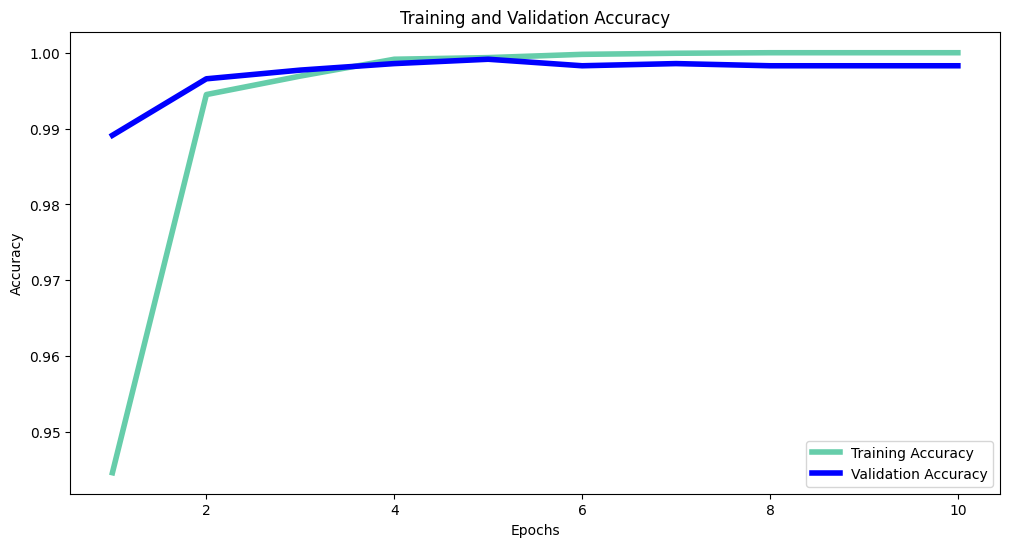

In [32]:
# Plot the training and validation accuracy for each epoch
def plot_accuracy(history):
    epochs = range(1, len(history['train_acc']) + 1)
    plt.figure(figsize=(12, 6))

    plt.plot(epochs, history['train_acc'], color='mediumaquamarine', linewidth=4, label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], color='blue',  linewidth=4, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('./accuracy_plots.png')

plot_accuracy(history)


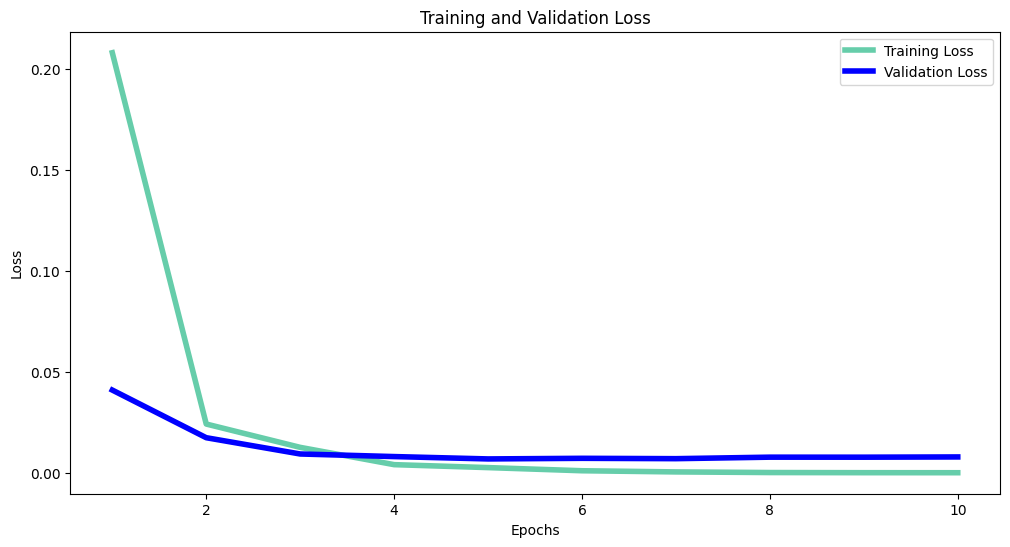

In [33]:
# Plot the training and validation loss for each epoch
def plot_loss(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 6))

    plt.plot(epochs, history['train_loss'], color='mediumaquamarine', linewidth=4, label='Training Loss')
    plt.plot(epochs, history['val_loss'], color='blue',  linewidth=4, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('./loss_plots.png')

plot_loss(history)


In [34]:
# Evaluate the model on the validation set
eval_loss, eval_accuracy = eval_model(model, testing_loader)
print(f"Validation Accuracy: {eval_accuracy}")
print(f"Validation Loss: {eval_loss}")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Validation Accuracy: 0.998281294757949
Validation Loss: 0.00795731809063266


In [35]:
# Validation set classification report
# This evaluates the model on the testing dataset and prints the classification report which includes precision, recall, F-score for each class labels.

# initialize empty lists to store true labels and preds
y_true = []
y_pred = []

#very similar steps to the above modelling part
model.eval()  #set model to eval mode, and disable gradient calculation
with torch.no_grad():
    for batch in testing_loader:
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)
        targets = batch['targets'].to(device)

        outputs = model(input_ids=ids, attention_mask=mask)
        preds = outputs.argmax(dim=1)  # Get the predicted class by finding the index with the highest score

        y_true.extend(targets.cpu().numpy())  # Append true labels to the list
        y_pred.extend(preds.cpu().numpy())    # Append predicted labels to the list

print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

                               precision    recall  f1-score   support

                      control       1.00      1.00      1.00        42
          driver intervention       1.00      1.00      1.00       446
        environmental factors       0.97      0.99      0.98        69
              hardware issues       1.00      1.00      1.00       299
localization & mapping issues       1.00      0.96      0.98        50
                        other       0.98      1.00      0.99        56
            perception issues       1.00      1.00      1.00      1261
              planning issues       1.00      1.00      1.00      1224
                      traffic       1.00      1.00      1.00        44

                     accuracy                           1.00      3491
                    macro avg       0.99      0.99      0.99      3491
                 weighted avg       1.00      1.00      1.00      3491



In [30]:
# Training set classification report

y_true = []
y_pred = []

model.train()
with torch.no_grad():
    for batch in training_loader:
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)
        targets = batch['targets'].to(device)

        outputs = model(input_ids=ids, attention_mask=mask)
        preds = outputs.argmax(dim=1)

        y_true.extend(targets.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


                               precision    recall  f1-score   support

                      control       1.00      1.00      1.00       221
          driver intervention       1.00      1.00      1.00      1830
        environmental factors       1.00      1.00      1.00       227
              hardware issues       1.00      1.00      1.00      1395
localization & mapping issues       1.00      1.00      1.00       199
                        other       1.00      1.00      1.00       236
            perception issues       1.00      1.00      1.00      4852
              planning issues       1.00      1.00      1.00      4839
                      traffic       1.00      1.00      1.00       164

                     accuracy                           1.00     13963
                    macro avg       1.00      1.00      1.00     13963
                 weighted avg       1.00      1.00      1.00     13963



### Saving the model

In [31]:
# Saving the files for re-use

output_model_file = './pytorch_distilbert_disengagementreports.bin'
output_vocab_file = './vocab_distilbert_disengagementreports.bin'

model_to_save = model
torch.save(model_to_save, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)


('./vocab_distilbert_disengagementreports.bin',)